In [10]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

# Data Cleaning:

In [11]:
options = pd.read_csv('options_1h.csv')
options.head(10)

,#RIC,Alias Underlying RIC,Domain,Date-Time,Type,Open,High,Low,Last,Volume,...,Open Bid,High Bid,Low Bid,Close Bid,No. Bids,Open Ask,High Ask,Low Ask,Close Ask,No. Asks
0,SPY,NaN,Market Price,2023-10-01T00:00:00.000000000-04,Intraday 1Hour,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,SPYA162621500.U,NaN,Market Price,2023-10-01T00:00:00.000000000-04,Intraday 1Hour,NaN,NaN,NaN,NaN,NaN,...,224.5,224.5,224.5,224.5,0.0,229.5,229.5,229.5,229.5,0.0
2,SPYA162622000.U,NaN,Market Price,2023-10-01T00:00:00.000000000-04,Intraday 1Hour,NaN,NaN,NaN,NaN,NaN,...,220.0,220.0,220.0,220.0,0.0,225.0,225.0,225.0,225.0,0.0
3,SPYA162622500.U,NaN,Market Price,2023-10-01T00:00:00.000000000-04,Intraday 1Hour,NaN,NaN,NaN,NaN,NaN,...,216.0,216.0,216.0,216.0,0.0,221.0,221.0,221.0,221.0,0.0
4,SPYA162623000.U,NaN,Market Price,2023-10-01T00:00:00.000000000-04,Intraday 1Hour,NaN,NaN,NaN,NaN,NaN,...,211.5,211.5,211.5,211.5,0.0,216.5,216.5,216.5,216.5,0.0
5,SPYA162623500.U,NaN,Market Price,2023-10-01T00:00:00.000000000-04,Intraday 1Hour,NaN,NaN,NaN,NaN,NaN,...,207.5,207.5,207.5,207.5,0.0,212.5,212.5,212.5,212.5,0.0
6,SPYA162624000.U,NaN,Market Price,2023-10-01T00:00:00.000000000-04,Intraday 1Hour,NaN,NaN,NaN,NaN,NaN,...,203.0,203.0,203.0,203.0,0.0,208.0,208.0,208.0,208.0,0.0
7,SPYA162624500.U,NaN,Market Price,2023-10-01T00:00:00.000000000-04,Intraday 1Hour,NaN,NaN,NaN,NaN,NaN,...,199.0,199.0,199.0,199.0,0.0,204.0,204.0,204.0,204.0,0.0
8,SPYA162625000.U,NaN,Market Price,2023-10-01T00:00:00.000000000-04,Intraday 1Hour,NaN,NaN,NaN,NaN,NaN,...,195.0,195.0,195.0,195.0,0.0,200.0,200.0,200.0,200.0,0.0
9,SPYA162625500.U,NaN,Market Price,2023-10-01T00:00:00.000000000-04,Intraday 1Hour,NaN,NaN,NaN,NaN,NaN,...,190.5,190.5,190.5,190.5,0.0,195.5,195.5,195.5,195.5,0.0


In [12]:
options['Mid Open'] = (options['Open Bid'] + options['Open Ask'])/2
options['Mid Close'] = (options['Close Bid'] + options['Close Ask'])/2
options = options[options['Open'].isna() == False].reset_index(drop=True)

In [13]:
spot = []
for i in range(options.shape[0]):
    if options['#RIC'][i] == 'SPY':
        val = options['Last'][i]
    
    spot.append(val)

options['Spot'] = spot
options = options[options['#RIC'] != 'SPY'].reset_index(drop=True)

In [14]:
# Credit: Harshil Cherukuri

ORD_UPPERCASE_ADJ_CALLS = 64
ORD_UPPERCASE_ADJ_PUTS = 76
OPRA_NONROOT_LEN = 10

# return root,strike,expiry,type - eg. MSFT,157.70,2020-01-17,call
def parse_opra_ric(opra_ric: str):
    # skip null values - but, why are any of these null?
    if pd.isnull(opra_ric):
        return (None,None,None,None)

    try:
        ric, exchange_code = tuple(opra_ric.split("."))
    except:
        print(opra_ric)
        return(None,None,None,None)

    if exchange_code not in ["U"]:
        return (None,None,None,None)

    root_len = len(ric) - OPRA_NONROOT_LEN
    #root_len = len(ric)
    root = ric[:root_len]

    expiry_day = ric[-9:-7]
    raw_expiry_year = ric[-7:-5]
    if int(raw_expiry_year) <= 72:
        expiry_year = "20"+raw_expiry_year
    else:
        expiry_year = "19"+raw_expiry_year
    
    raw_expiry_month_put_or_call = ric[-10:-9]
    strike_ge_1000 = raw_expiry_month_put_or_call.islower()

    if ord(raw_expiry_month_put_or_call.upper()) <= (12 + ORD_UPPERCASE_ADJ_CALLS):
        contract_type = "call"
        expiry_month = str(ord(raw_expiry_month_put_or_call.upper()) - ORD_UPPERCASE_ADJ_CALLS).zfill(2)
    else:
        contract_type = "put"
        expiry_month = str(ord(raw_expiry_month_put_or_call.upper()) - ORD_UPPERCASE_ADJ_PUTS).zfill(2)

    expiry = f"{expiry_year}-{expiry_month}-{expiry_day}"

    if strike_ge_1000:
        strike = float(ric[-5:]) / 10
    else:
        strike = float(ric[-5:]) / 100

    return [root, strike, expiry, contract_type]

In [15]:
opt_attr = []
for i in range(options.shape[0]):
    vals = pd.Series(parse_opra_ric(options['#RIC'][i]))
    opt_attr.append(vals)

opt_attr = pd.concat(opt_attr, axis=1).transpose()
opt_attr.columns = ['Ticker', 'Strike', 'Expiry', 'Opt Type']
opt_attr.head()

,Ticker,Strike,Expiry,Opt Type
0,SPY,375.0,2026-01-16,call
1,SPY,420.0,2026-01-16,call
2,SPY,425.0,2026-01-16,call
3,SPY,440.0,2026-01-16,call
4,SPY,480.0,2026-01-16,call


In [16]:
optionsData = pd.concat([options, opt_attr], axis=1)
optionsData['T'] = [(pd.to_datetime(optionsData['Expiry'][i]) - \
                     pd.to_datetime(optionsData['Date-Time'][i][0:10])).days/252 for i in range(optionsData.shape[0])]
optionsData.tail(10)

,#RIC,Alias Underlying RIC,Domain,Date-Time,Type,Open,High,Low,Last,Volume,...,Close Ask,No. Asks,Mid Open,Mid Close,Spot,Ticker,Strike,Expiry,Opt Type,T
363911,SPYX292341600.U,NaN,Market Price,2023-11-01T16:00:00.000000000-04,Intraday 1Hour,7.27,7.27,7.25,7.25,29.0,...,7.33,170.0,7.240,7.285,422.66,SPY,416.0,2023-12-29,put,0.230159
363912,SPYX292341700.U,NaN,Market Price,2023-11-01T16:00:00.000000000-04,Intraday 1Hour,7.52,7.52,7.52,7.52,1.0,...,7.64,169.0,7.560,7.595,422.66,SPY,417.0,2023-12-29,put,0.230159
363913,SPYX292341900.U,NaN,Market Price,2023-11-01T16:00:00.000000000-04,Intraday 1Hour,8.22,8.22,8.22,8.22,1.0,...,8.29,172.0,8.200,8.245,422.66,SPY,419.0,2023-12-29,put,0.230159
363914,SPYX292342000.U,NaN,Market Price,2023-11-01T16:00:00.000000000-04,Intraday 1Hour,8.58,8.60,8.53,8.53,7.0,...,8.61,183.0,8.510,8.575,422.66,SPY,420.0,2023-12-29,put,0.230159
363915,SPYX292342300.U,NaN,Market Price,2023-11-01T16:00:00.000000000-04,Intraday 1Hour,9.73,9.75,9.72,9.72,34.0,...,9.76,175.0,9.675,9.700,422.66,SPY,423.0,2023-12-29,put,0.230159
363916,SPYX292342400.U,NaN,Market Price,2023-11-01T16:00:00.000000000-04,Intraday 1Hour,10.07,10.08,10.07,10.08,2.0,...,10.17,178.0,10.110,10.110,422.66,SPY,424.0,2023-12-29,put,0.230159
363917,SPYX292342500.U,NaN,Market Price,2023-11-01T16:00:00.000000000-04,Intraday 1Hour,10.50,10.50,10.50,10.50,1.0,...,10.58,178.0,10.515,10.535,422.66,SPY,425.0,2023-12-29,put,0.230159
363918,SPYX292343000.U,NaN,Market Price,2023-11-01T16:00:00.000000000-04,Intraday 1Hour,12.88,12.88,12.85,12.85,4.0,...,12.98,167.0,12.935,12.910,422.66,SPY,430.0,2023-12-29,put,0.230159
363919,SPYX292345500.U,NaN,Market Price,2023-11-01T16:00:00.000000000-04,Intraday 1Hour,32.56,32.56,32.56,32.56,2.0,...,32.94,94.0,32.295,32.405,422.66,SPY,455.0,2023-12-29,put,0.230159
363920,SPYX292345700.U,NaN,Market Price,2023-11-01T16:00:00.000000000-04,Intraday 1Hour,34.32,34.33,34.32,34.33,2.0,...,34.94,91.0,34.355,34.405,422.66,SPY,457.0,2023-12-29,put,0.230159


# Finding Implied Vol:

In [17]:
from scipy.stats import norm

In [18]:
# Returns the Black-Scholes-Merton (European) option price
def PV_BlackScholes(S, K, vol, r, t, d, typeof):
    # typeof == 'call' or 'put'
    d1 = (np.log(S/K) + (r-d+(pow(vol, 2)/2))*t)/(vol*np.sqrt(t))
    d2 = d1 - vol*np.sqrt(t)
    if typeof == 'call':
        return S*np.exp(-d*t)*norm.cdf(d1) - K*np.exp(-r*t)*norm.cdf(d2)
    else:
        return K*np.exp(-r*t)*norm.cdf(-d2) - S*np.exp(-d*t)*norm.cdf(-d1)

In [19]:
def newtonImpliedVol(index: int, x0: float, error=0.001):
    S = optionsData['Spot'][index]
    K = optionsData['Strike'][index]
    r = 0.03
    d = 0
    T = optionsData['T'][index]
    typeof = optionsData['Opt Type'][index]
    true_price = optionsData['Last'][index]
    
    while PV_BlackScholes(S, K, x0, r, T, d, typeof) - true_price > error:
        f = PV_BlackScholes(S, K, x0, r, T, d, typeof) - true_price
        d1 = (np.log(S/K) + (r-d+pow(x0, 2)/2)*T)/(x0*np.sqrt(T))
        f_prime = S*np.sqrt(T)*norm.pdf(d1)
        x0 = x0 - (f/f_prime)
        
    return x0

# Selection Criteria:

In [20]:
optTrain = pd.read_csv('df_train_no_nan.csv')  # Credit: Harshil Cherukuri
optTrain.index = optTrain['Date-Time']
optTrain = optTrain.drop('Date-Time', axis='columns')
optTrain.head()

,SPYA192444000.U,SPYK172343000.U,SPYK172343500.U,SPYK172344000.U,SPYK172344500.U,SPYK172345000.U,SPYL152344000.U,SPYM192440000.U,SPYW032341000.U,SPYW172340000.U,SPYW172340500.U,SPYW172341000.U,SPYW172341500.U,SPYW172342000.U,SPYW172342200.U,SPYW172342500.U,SPYW172343000.U,SPYX152340000.U,SPYX152341000.U,SPYX152342000.U
Date-Time,,,,,,,,,,,,,,,,,,,,
2023-10-02T09:00:00.000000000-04,0.006398,0.004759,-0.001473,-0.004283,0.003328,0.000000,0.004727,-0.008914,-0.043697,-0.029126,-0.029457,-0.027127,-0.025540,-0.020376,-0.022923,-0.022500,-0.016983,-0.016949,-0.016990,-0.011014
2023-10-02T10:00:00.000000000-04,-0.032461,-0.017039,-0.011211,-0.034372,-0.035294,-0.036620,-0.076184,0.095111,0.001724,-0.005871,-0.007788,0.001248,0.000000,-0.009360,0.001441,0.005044,0.004525,-0.011223,-0.001623,-0.002899
2023-10-02T11:00:00.000000000-04,-0.027054,-0.031453,-0.035552,-0.037862,-0.041885,-0.046784,-0.037293,0.002421,0.020690,0.003945,0.003125,0.011208,0.013834,0.022047,0.023055,0.024467,0.018868,0.006810,0.009740,0.013937
2023-10-02T12:00:00.000000000-04,-0.032973,-0.040965,-0.042453,-0.048837,-0.051376,-0.055728,-0.038102,0.047238,0.096990,0.085938,0.085139,0.083436,0.078488,0.072197,0.072078,0.068987,0.061106,0.062992,0.058540,0.053592
2023-10-02T13:00:00.000000000-04,0.024026,0.028070,0.030428,0.033048,0.030948,0.039604,0.026906,-0.033613,-0.067176,-0.057451,-0.055556,-0.055305,-0.051167,-0.047926,-0.047059,-0.046724,-0.041571,-0.040212,-0.040000,-0.035116


In [21]:
# Filtering the optionsData df beforehand so that it doesn't have to calculate IV 300,000+ times

indices = np.where(optionsData['#RIC'] == optTrain.columns[0])[0]
for i in range(1, len(optTrain.columns)):
    indices = np.concatenate([indices, np.where(optionsData['#RIC'] == optTrain.columns[i])[0]])

indices

array([    61,   2237,   4428, ..., 360191, 362725, 363881])

In [22]:
optionsData = optionsData.iloc[indices, :].reset_index(drop=True)
optionsData = optionsData.reset_index(drop=True)

In [23]:
impVol = [newtonImpliedVol(i, 0.75) for i in range(optionsData.shape[0])]
optionsData['IV'] = impVol

In [24]:
# Implied volatility time series
iv_ts = optionsData.pivot(index='Date-Time', columns='#RIC', values='IV')
iv_ts

#RIC,SPYA192444000.U,SPYK172343000.U,SPYK172343500.U,SPYK172344000.U,SPYK172344500.U,SPYK172345000.U,SPYL152344000.U,SPYM192440000.U,SPYW032341000.U,SPYW172340000.U,SPYW172340500.U,SPYW172341000.U,SPYW172341500.U,SPYW172342000.U,SPYW172342200.U,SPYW172342500.U,SPYW172343000.U,SPYX152340000.U,SPYX152341000.U,SPYX152342000.U
Date-Time,,,,,,,,,,,,,,,,,,,,
2023-10-02T09:00:00.000000000-04,0.112387,0.132685,0.127544,0.123590,0.118026,0.113379,0.120534,0.164480,0.159199,0.166356,0.159259,0.154335,0.146575,0.141036,0.137093,0.130520,0.123811,0.166246,0.154042,0.140220
2023-10-02T10:00:00.000000000-04,0.110519,0.130340,0.127015,0.122300,0.116352,0.111361,0.119656,0.164128,0.156564,0.167393,0.160093,0.153004,0.146357,0.141380,0.133408,0.130970,0.124541,0.166553,0.154620,0.140126
2023-10-02T11:00:00.000000000-04,0.110250,0.130890,0.127079,0.122371,0.117405,0.112446,0.120335,0.163601,0.154102,0.165167,0.159128,0.152240,0.146301,0.139478,0.137176,0.129132,0.126125,0.165458,0.154606,0.139271
2023-10-02T12:00:00.000000000-04,0.112443,0.132896,0.130098,0.123949,0.118330,0.113614,0.121472,0.164471,0.156711,0.166230,0.160091,0.154375,0.147683,0.141131,0.136004,0.130400,0.125900,0.166641,0.154907,0.139251
2023-10-02T13:00:00.000000000-04,0.111455,0.130283,0.127330,0.122465,0.116864,0.113563,0.122056,0.162407,0.154812,0.162905,0.157116,0.150380,0.144031,0.140049,0.133481,0.130146,0.121583,0.164489,0.154136,0.139732
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-11-01T12:00:00.000000000-04,0.111709,0.127625,0.121471,0.118264,0.117778,0.125845,0.114008,0.159729,0.211921,0.171597,0.162439,0.153139,0.144625,0.134336,0.131486,0.129335,0.132881,0.164053,0.152124,0.135970
2023-11-01T13:00:00.000000000-04,0.111190,0.126771,0.119580,0.116360,0.114731,0.124353,0.113041,0.159526,0.210050,0.171380,0.162310,0.153007,0.146558,0.134328,0.131886,0.132525,0.124664,0.164060,0.151664,0.136345
2023-11-01T14:00:00.000000000-04,0.109377,0.123415,0.116690,0.114432,0.113687,0.117258,0.112013,0.158661,0.203313,0.170389,0.159557,0.151374,0.141478,0.132704,0.128898,0.124502,0.124044,0.162407,0.150093,0.134075


# Trading Strategies:

## Basic Implied Volatility Strategy:

For this strategy, at each time step, we are longing the x options with the highest implied vol and shorting the x with the lowest implied vol.

In [25]:
top = 3
strategyRet = []
for i in range(optTrain.shape[0]):
    colIndices = [*np.argsort(iv_ts.iloc[i, :])[0:top]] + [*np.argsort(iv_ts.iloc[i, :])[-top:]]
    longShort = np.array(top*[1] + top*[-1]).T
    ret = optTrain.iloc[i, colIndices]
    strategyRet.append(longShort @ ret)

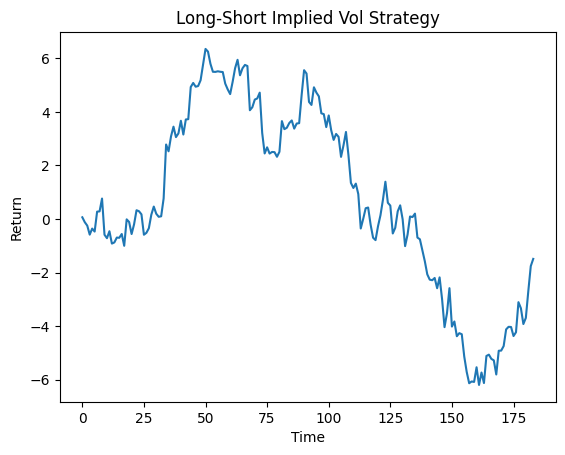

In [26]:
strategyRet = np.array(strategyRet)
# plt.plot(np.cumprod(1+strategyRet)-1)
plt.plot(np.cumsum(strategyRet))
plt.xlabel("Time")
plt.ylabel("Return")
plt.title("Long-Short Implied Vol Strategy")
plt.show()

## Standard Mean-Variance:

In [27]:
one = np.ones(optTrain.shape[1])
target = 0.05
mu = np.mean(optTrain, axis=0)
cov = optTrain.cov()
A = one.T @ np.linalg.inv(cov) @ one
B = one.T @ np.linalg.inv(cov) @ mu
C = mu.T @ np.linalg.inv(cov) @ mu
delta = A*C - B*B

lam = (C - target*B)/delta
gamma = (target*A - B)/delta
w_opt = lam*np.linalg.inv(cov) @ one + gamma*np.linalg.inv(cov) @ mu
print("Optimized portfolio weights: ", w_opt)

Optimized portfolio weights:  [  7.08677658   3.98565615  -2.27863978  -6.0232665    2.01967573
  -0.38136631  -0.18939282   1.83582897  -2.87240063  -2.13812206
   3.40476243  -3.53774941  11.1965508    4.05131581  -2.31898907
   9.91266827  -1.74101698   7.54729857 -14.30231768 -14.25727207]


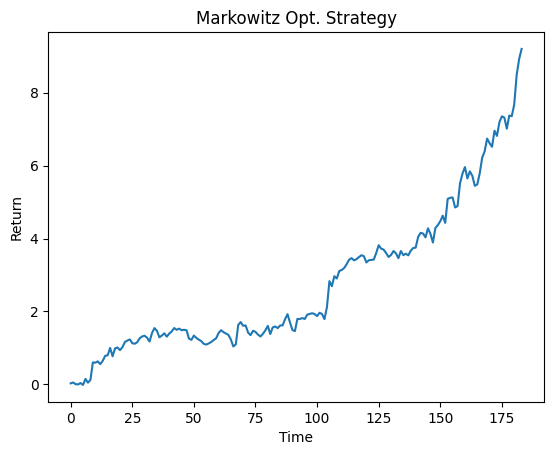

In [28]:
strategyRet = np.array(optTrain) @ w_opt
# plt.plot(np.cumprod(1+strategyRet)-1)
plt.plot(np.cumsum(strategyRet))
plt.xlabel("Time")
plt.ylabel("Return")
plt.title("Markowitz Opt. Strategy")
plt.show()

## Dynamic Optimization:

In [29]:
from cvxopt import matrix, solvers
solvers.options["show_progress"] = False

In [30]:
def dynamicPortfolio(returns, window: int, top: int, min_w=0.01, max_w=0.4, balance=1):
        """
        Arguments:
        returns = Data frame or array of time series returns
        window = Sliding window which we use to slice the returns array to calculate the covariance matrix
        top = Selection criterion at each time step. We select the highest and lowest (top) options by implied vol
        min_w = Minimum weight for any particular option
        max_w = Maximum weight for any particular option
        balance = Portfolio rebalancing frequency
        """
        rows = returns.shape[0]
        cols = 2*top
        strategyRet = []
        for i in range(rows-window):
            if i % balance == 0:
                colIndices = [*np.argsort(iv_ts.iloc[i, :])[0:top]] + [*np.argsort(iv_ts.iloc[i, :])[-top:]]
                subset = returns.iloc[i:(i+window), colIndices]
                mu = np.mean(subset, axis=0)
                cov = np.array(subset.cov())
                Q = matrix(cov)
                r = matrix(-mu)
                # r = matrix(0.0, (cols, 1))
                G = matrix(np.vstack( [-np.identity(cols), np.identity(cols)] ))
                h = matrix(np.concatenate( (-min_w*np.ones(cols), max_w*np.ones(cols)) ))
                A = matrix(1.0, (1, cols))
                b = matrix(1.0)
                w = solvers.qp(Q, r, G, h, A, b)['x']
                ret = np.array(subset.iloc[0, :]).T @ np.array([*w])
                strategyRet.append(ret)
        
        return strategyRet

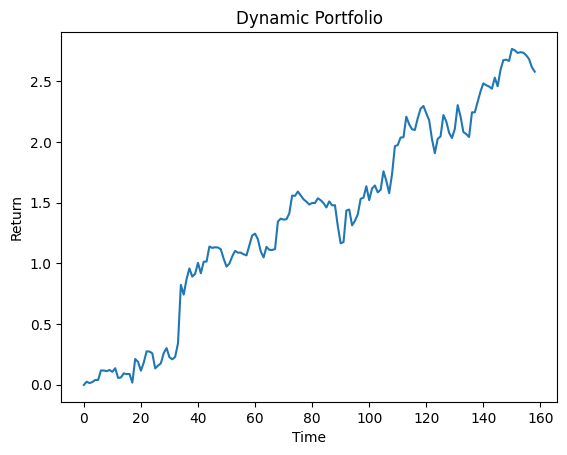

In [31]:
strategyRet = dynamicPortfolio(returns=optTrain, window=25, top=3)
plt.plot(np.cumsum(strategyRet))
plt.xlabel("Time")
plt.ylabel("Return")
plt.title("Dynamic Portfolio")
plt.show()

# Option Greeks Calculations

In [ ]:
#AARON
import pandas as pd
df = pd.read_csv('5m_intraday.csv')

In [33]:
optTrain.head()

,SPYA192444000.U,SPYK172343000.U,SPYK172343500.U,SPYK172344000.U,SPYK172344500.U,SPYK172345000.U,SPYL152344000.U,SPYM192440000.U,SPYW032341000.U,SPYW172340000.U,SPYW172340500.U,SPYW172341000.U,SPYW172341500.U,SPYW172342000.U,SPYW172342200.U,SPYW172342500.U,SPYW172343000.U,SPYX152340000.U,SPYX152341000.U,SPYX152342000.U
Date-Time,,,,,,,,,,,,,,,,,,,,
2023-10-02T09:00:00.000000000-04,0.006398,0.004759,-0.001473,-0.004283,0.003328,0.000000,0.004727,-0.008914,-0.043697,-0.029126,-0.029457,-0.027127,-0.025540,-0.020376,-0.022923,-0.022500,-0.016983,-0.016949,-0.016990,-0.011014
2023-10-02T10:00:00.000000000-04,-0.032461,-0.017039,-0.011211,-0.034372,-0.035294,-0.036620,-0.076184,0.095111,0.001724,-0.005871,-0.007788,0.001248,0.000000,-0.009360,0.001441,0.005044,0.004525,-0.011223,-0.001623,-0.002899
2023-10-02T11:00:00.000000000-04,-0.027054,-0.031453,-0.035552,-0.037862,-0.041885,-0.046784,-0.037293,0.002421,0.020690,0.003945,0.003125,0.011208,0.013834,0.022047,0.023055,0.024467,0.018868,0.006810,0.009740,0.013937
2023-10-02T12:00:00.000000000-04,-0.032973,-0.040965,-0.042453,-0.048837,-0.051376,-0.055728,-0.038102,0.047238,0.096990,0.085938,0.085139,0.083436,0.078488,0.072197,0.072078,0.068987,0.061106,0.062992,0.058540,0.053592
2023-10-02T13:00:00.000000000-04,0.024026,0.028070,0.030428,0.033048,0.030948,0.039604,0.026906,-0.033613,-0.067176,-0.057451,-0.055556,-0.055305,-0.051167,-0.047926,-0.047059,-0.046724,-0.041571,-0.040212,-0.040000,-0.035116


In [39]:
#optionsData.head().to_csv("test.csv")
optionsData1 = optionsData.head()
optionsData1

,#RIC,Alias Underlying RIC,Domain,Date-Time,Type,Open,High,Low,Last,Volume,...,No. Asks,Mid Open,Mid Close,Spot,Ticker,Strike,Expiry,Opt Type,T,IV
0,SPYA192444000.U,NaN,Market Price,2023-10-02T09:00:00.000000000-04,Intraday 1Hour,10.16,10.47,10.09,10.30,195.0,...,390.0,10.160,10.225,426.7238,SPY,440.0,2024-01-19,call,0.43254,0.112387
1,SPYA192444000.U,NaN,Market Price,2023-10-02T10:00:00.000000000-04,Intraday 1Hour,10.00,10.69,9.92,9.92,273.0,...,742.0,10.320,9.985,426.3650,SPY,440.0,2024-01-19,call,0.43254,0.110519
2,SPYA192444000.U,NaN,Market Price,2023-10-02T11:00:00.000000000-04,Intraday 1Hour,10.29,10.65,9.62,9.62,177.0,...,763.0,9.980,9.710,425.8096,SPY,440.0,2024-01-19,call,0.43254,0.110250
3,SPYA192444000.U,NaN,Market Price,2023-10-02T12:00:00.000000000-04,Intraday 1Hour,9.70,9.70,9.34,9.38,271.0,...,742.0,9.705,9.385,424.8200,SPY,440.0,2024-01-19,call,0.43254,0.112443
4,SPYA192444000.U,NaN,Market Price,2023-10-02T13:00:00.000000000-04,Intraday 1Hour,9.46,9.79,9.30,9.60,79.0,...,711.0,9.365,9.590,425.4973,SPY,440.0,2024-01-19,call,0.43254,0.111455


In [50]:
delta_ts = df.pivot(index='Date-Time', columns='#RIC', values='Delta')
delta_ts

#RIC,SPYA192444000.U
Date-Time,
2023-10-02 13:00:00+00:00,0.931319
2023-10-02 14:00:00+00:00,0.931908
2023-10-02 15:00:00+00:00,0.931829
2023-10-02 16:00:00+00:00,0.930674
2023-10-02 17:00:00+00:00,0.931188


In [85]:
import numpy as np
from scipy.stats import norm
import pandas as pd

df = optionsData

df['Date-Time'] = pd.to_datetime(df['Date-Time'], utc=True)
df['Expiry'] = pd.to_datetime(df['Expiry']).dt.tz_convert('UTC')
df['time_to_expiry'] = df['Expiry'] - df['Date-Time']

r = 0.0533

def calculate_delta(row):
    S = row['Spot']
    K = row['Strike']
    sigma = row['IV']
    T = row['time_to_expiry'].days + row['time_to_expiry'].seconds / (24 * 3600)
    
    d1 = (np.log(S / K) + (r + (sigma**2) / 2) * T) / (sigma * np.sqrt(T))
    
    if row['Opt Type'] == 'call':
        return norm.cdf(d1)
    elif row['Opt Type'] == 'put':
        return norm.cdf(d1) - 1

df['Delta'] = df.apply(calculate_delta, axis=1)

def calculate_gamma(row):
    sigma = row['IV']
    T = row['time_to_expiry'].days + row['time_to_expiry'].seconds / (24 * 3600)

    d1 = (np.log(row['Spot'] / row['Strike']) + (r + (sigma**2) / 2) * T) / (sigma * np.sqrt(T))

    gamma = np.exp(-d1**2 / 2) / (row['Spot'] * sigma * np.sqrt(T))
    
    return gamma

df['Gamma'] = df.apply(calculate_gamma, axis=1)

def calculate_theta(row):
    sigma = row['IV']
    T = row['time_to_expiry'].days + row['time_to_expiry'].seconds / (24 * 3600)

    d1 = (np.log(row['Spot'] / row['Strike']) + (r + (sigma**2) / 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    
    if row['Opt Type'] == 'call':
        theta = -row['Spot'] * sigma * np.exp(-d1**2 / 2) / (2 * np.sqrt(T)) - r * row['Strike'] * np.exp(-r * T) * norm.cdf(d2)
    elif row['Opt Type'] == 'put':
        theta = -row['Spot'] * sigma * np.exp(-d1**2 / 2) / (2 * np.sqrt(T)) + r * row['Strike'] * np.exp(-r * T) * norm.cdf(-d2)
    
    return theta

df['Theta'] = df.apply(calculate_theta, axis=1)

def calculate_vega(row):
    sigma = row['IV']
    T = row['time_to_expiry'].days + row['time_to_expiry'].seconds / (24 * 3600)

    d1 = (np.log(row['Spot'] / row['Strike']) + (r + (sigma**2) / 2) * T) / (sigma * np.sqrt(T))

    vega = row['Spot'] * np.sqrt(T) * norm.pdf(d1)
    
    return vega

df['Vega'] = df.apply(calculate_vega, axis=1)

df.to_csv("Data_with_greeks.csv")


In [81]:
delta_ts = df.pivot(index='Date-Time', columns='#RIC', values='Delta')
delta_ts

#RIC,SPYA192444000.U,SPYK172343000.U,SPYK172343500.U,SPYK172344000.U,SPYK172344500.U,SPYK172345000.U,SPYL152344000.U,SPYM192440000.U,SPYW032341000.U,SPYW172340000.U,SPYW172340500.U,SPYW172341000.U,SPYW172341500.U,SPYW172342000.U,SPYW172342200.U,SPYW172342500.U,SPYW172343000.U,SPYX152340000.U,SPYX152341000.U,SPYX152342000.U
Date-Time,,,,,,,,,,,,,,,,,,,,
2023-10-02 13:00:00+00:00,1.000000,0.999176,0.999371,0.999495,0.999651,0.999751,0.999991,-0.000010,-0.008917,-0.002729,-0.002241,-0.001944,-0.001470,-0.001182,-0.000982,-0.000692,-0.000465,-0.000228,-0.000128,-0.000054
2023-10-02 14:00:00+00:00,1.000000,0.999277,0.999387,0.999535,0.999692,0.999791,0.999991,-0.000010,-0.008389,-0.002833,-0.002322,-0.001859,-0.001466,-0.001211,-0.000807,-0.000717,-0.000494,-0.000232,-0.000133,-0.000054
2023-10-02 15:00:00+00:00,1.000000,0.999245,0.999377,0.999527,0.999660,0.999766,0.999991,-0.000009,-0.007916,-0.002666,-0.002263,-0.001819,-0.001475,-0.001112,-0.001004,-0.000647,-0.000557,-0.000222,-0.000134,-0.000051
2023-10-02 16:00:00+00:00,1.000000,0.999138,0.999236,0.999463,0.999628,0.999736,0.999989,-0.000010,-0.008588,-0.002783,-0.002365,-0.001998,-0.001585,-0.001223,-0.000955,-0.000710,-0.000557,-0.000237,-0.000138,-0.000051
2023-10-02 17:00:00+00:00,1.000000,0.999263,0.999359,0.999517,0.999670,0.999737,0.999988,-0.000009,-0.008158,-0.002504,-0.002129,-0.001706,-0.001346,-0.001158,-0.000829,-0.000698,-0.000409,-0.000214,-0.000132,-0.000053
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-11-01 16:00:00+00:00,0.999998,0.966891,0.970014,0.970927,0.969673,0.961104,0.999651,-0.000110,-0.305442,-0.052190,-0.048544,-0.044386,-0.040373,-0.034721,-0.033299,-0.032708,-0.037174,-0.003232,-0.002323,-0.001234
2023-11-01 17:00:00+00:00,0.999999,0.967496,0.971445,0.972396,0.972116,0.962301,0.999678,-0.000109,-0.304994,-0.052129,-0.048527,-0.044358,-0.041799,-0.034770,-0.033651,-0.035174,-0.030876,-0.003236,-0.002286,-0.001260
2023-11-01 18:00:00+00:00,0.999999,0.970309,0.973909,0.974141,0.973186,0.968586,0.999708,-0.000103,-0.299121,-0.051294,-0.046519,-0.043008,-0.037953,-0.033342,-0.031201,-0.028902,-0.030173,-0.003062,-0.002141,-0.001111


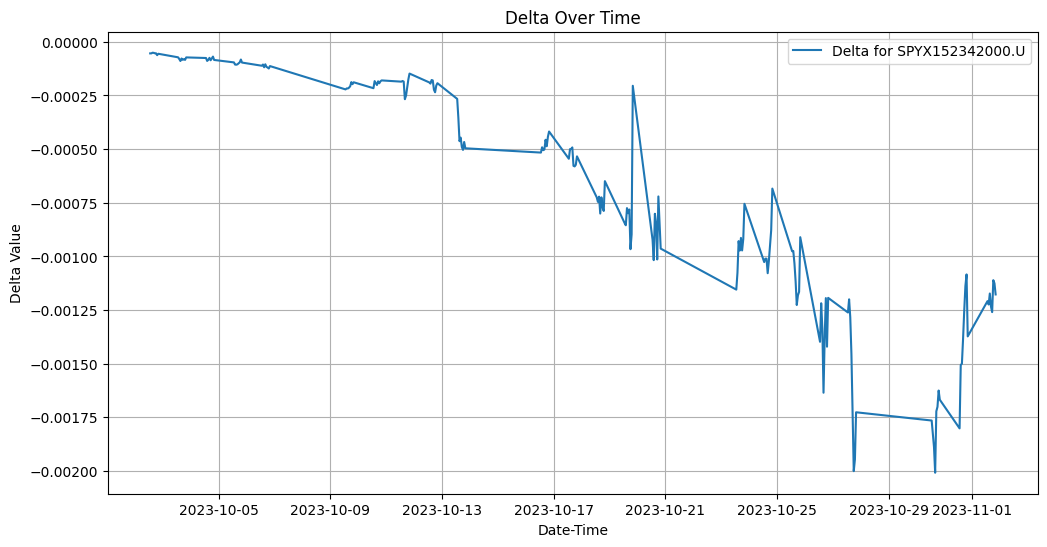

In [84]:
import matplotlib.pyplot as plt

option_ric_to_plot = 'SPYX152342000.U'

plt.figure(figsize=(12, 6))
plt.plot(delta_ts.index, delta_ts[option_ric_to_plot], label=f'Delta for {option_ric_to_plot}')
plt.title('Delta Over Time')
plt.xlabel('Date-Time')
plt.ylabel('Delta Value')
plt.legend()
plt.grid(True)
plt.show()